In [ ]:
import librosa
import librosa.display
import IPython.display as ipd
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt

def echo(root_path=None, cor_p=0.9, len_echo=2, times_echo=2, hop_length=512):

    """
    Функция обнаружения эхо эффекта в аудиосигнале.

    Аргументы функции:
    root_path - полный путь к файлу + полное название файла с иследуемой аудиозаписью (тип - str)
    cor_p - порог обнаружения эхо: корреляция выше этого значения считается первым признаком наличия эхо (тип - float, диапазон значений [0, 1])
    len_echo - минимальная длительность события эхо для детектирования явления (тип - int, измеряется в фреймах)
    times_echo - минимальное количество повторений эхо для детектирования явления (тип - int, измеряется в фреймах)
    hop_length - размер окна для кратковременного преобразования Фурье (тип - int, кратное степени 2)

    Результатом работы функции является:
    Волновой график исследуемого аудиосигнала, где зеленым цветом закрашена область возможного нахождения эффекта эхо
    или
    Сообщение: 'В данном аудиосигнале эхо не найдено!'

    """
    # чтение файла
    x, sr = librosa.load(root_path, mono=True, sr = None)

    # кратковременное преобразование Фурье
    X = librosa.stft(x, hop_length=hop_length)
    Xmag = abs(X)

    # получение корреляционной матрицы
    cor = np.zeros((Xmag.shape[1] - 1, Xmag.shape[1] - 1)) # матрица для записи в нее результатов корреляции

    for i in range(Xmag.shape[1] - 1): # анализ каждого столбца на корреляю с каждым последующим

        seq = Xmag.T[i]
        for j in range(0, Xmag.shape[1] - 1 - i):
            seq2 = Xmag.T[i+j+1]
            result = scipy.stats.pearsonr(seq, seq2)
            cor[i][j] = round(result[0], 3) # анализ корреляции двух матриц и запись результата проверки в нулевую матрицу

    # формирование матрици корреляций с булевыми значениями
    cor_true = cor >= cor_p # порог обнаружения эхо

    point_echo = [] # список для записи отсечек эхо
    # проверяем каждую строку матрицы корреляции с булевыми значениями
    for i_num, i_val in enumerate(cor_true[ : -1 * times_echo]): # нужно проверить все строки кроме последних
        
        skan_core = [] # задаем ядро счетчика эха в строке, сюда записываем номера столбов эхо, далее идет условие его формирования в конкретной строке
        for bool_num, bool_ansver in enumerate(i_val): # скан значений строки - проходимся вдоль строки, ищем начало столба эхо

            if bool_ansver == True: # нашли начало столба эхо

                tru = 1 # счетчик последовательности совпадений вертикальных Тру, начало отсчета с 1
                for i_vert_skan in range(1, cor_true.shape[0]-i_num): # от найденной точки идем вниз по матрице корреляций с булевыми значениями

                    if i_num + i_vert_skan >= cor_true.shape[0]: # прекратить цикл, если индекс вышел за пределы массива
                        break
                    elif cor_true[i_num + i_vert_skan][bool_num] == False: # нету продолжения, заканчиваем цикл, продолжаем искать следующее значение в строке
                        break
                    else: # нашли продолжение! переставляем счетчик последовательности - глубины столба эхо
                        tru += 1

                if tru >= len_echo: # счетчи глубины столба эхо больше порога, предполагаем что это признак эхо!
                    
                    skan_core.append(bool_num) # запоминаем индекс столбца матрицы корелляции, где были замечены признаки эхо
        
        # действия внутри строки закончились, подытоживаем результат работы со строкой
        if len(skan_core) > times_echo: # проверка на наличие признаков эхов в строке

            steps_echo = [] # записываем сюда расстояние между каждым столбом эхо
            for num_sc, val_cs in enumerate(skan_core[:-1], 1): # цикл записи расстояний между столбами эхо

                steps_echo.append(skan_core[num_sc] - val_cs) # запоминаем расстояние между каждым столбом
            
            # проверить длину шагов - равны ли они с учетом области разброса
            echo_puls = 0 # счетчик - сколько раз расстояния между эхо оказались равны с учетом разброса в два фрейма
            for step in range(len(steps_echo) - 1):
                len_step = round(steps_echo[step+1] - steps_echo[step], 0)
                if len_step in range(-2, 3, 1): # совпадают ли длины шагов эхо с учетом разброса от -2 до 2 (если шаги равны, то ответ 0)
                    echo_puls += 1
            
            # зафиксировать результат
            if echo_puls >= times_echo: # В строке есть эхо! нужно запомнить эти отсечки, для последующей визуализации
                point_echo.append([i_num, skan_core]) # запомним индекс строки матрици корреляций и номера столбцов с эхо для дальнейшей интерпртации

        # !конец цикла прохода одной строки, начинаем все сначала для следующей строки!

    # обработка результатов - преобразование во фреймы, после во время

    if len(point_echo) >= times_echo: # проверка на наличие эхо в записи
        # данные во фреймы
        frames = []
        frames.append(point_echo[0][0]) # начальная точка - номер первой строки, где было замечано эхо
        frames.append(point_echo[-1][0] + point_echo[-1][-1][-1]) # конечная точка - номер последней строкии с эхо + смещение, где последний раз было замечено эхо

        # фреймы во время
        t = librosa.frames_to_time(frames, sr=sr)

        # визуализировать итоговый результат
        # диапозон возможного наличия эхо
        t1 = float(t[0])
        t2 = float(t[-1])

        #  График сигнала
        fig, ax = plt.subplots(figsize = (15, 5))
        librosa.display.waveplot(x, sr = sr) # визуализация исходного сигнала

        ax.axvspan(xmin = t1, xmax = t2, color = 'green', alpha = 0.2) # закрашивание указанной области

        plt.show()

    else:

        print('В данном аудиосигнале эхо не найдено!')

In [ ]:
# подключение диска
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


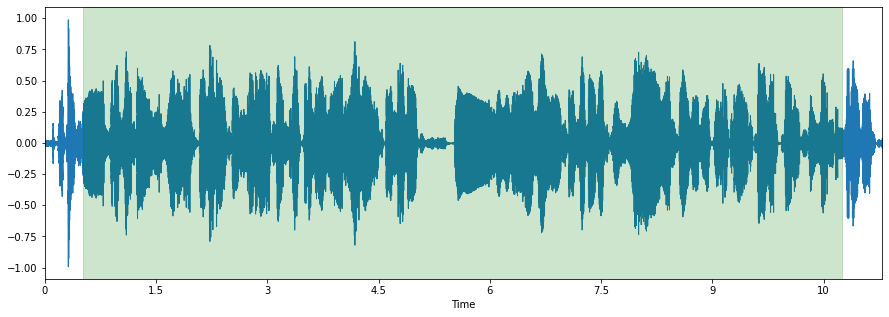

In [ ]:
p = 'gdrive/My Drive/Colab Notebooks/audio/defects/0111.wav' # пример пути  аудиофайлу
echo(p) # пример вызова функции